In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('../..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)
import electronTransportCode.exactSolution

%matplotlib widget

In [2]:
eSource, dS, NB_PARTICLES, sigmaArray, repeats = pickle.load(open('data/simargv.pkl', 'rb'))
bins = 500
nbSigma = sigmaArray.size
binRange = (-5.5, 5.5)

# Load analog estimators
analogTEE = np.empty((nbSigma, repeats, bins), dtype=float)
for i in range(nbSigma):
    for repeat in range(repeats):
        TEE = pickle.load(open(f'data/TEEAnalog{i}_{repeat}.pkl', 'rb'))[0]
        binCenter, binVal = TEE.getDensityData(bins=bins, binRange=binRange)
        analogTEE[i, repeat, :] = binVal

# Load KDMC estimators
KDMCTEE = np.empty((nbSigma, repeats, bins), dtype=float)
for i in range(nbSigma):
    for repeat in range(repeats):
        TEE = pickle.load(open(f'data/TEEKDMC{i}_{repeat}.pkl', 'rb'))[0]
        _, binVal = TEE.getDensityData(bins=bins, binRange=binRange)
        KDMCTEE[i, repeat, :] = binVal

# Load KDMC estimators
KDSMCTEE = np.empty((nbSigma, repeats, bins), dtype=float)
for i in range(nbSigma):
    for repeat in range(repeats):
        TEE = pickle.load(open(f'data/TEEKDSMC{i}_{repeat}.pkl', 'rb'))[0]
        _, binVal = TEE.getDensityData(bins=bins, binRange=binRange)
        KDSMCTEE[i, repeat, :] = binVal

print(f'{eSource=}')
print(f'{dS=}')
print(f'{NB_PARTICLES=}')
print(f'{sigmaArray=}')
print(f'{repeats=}')

eSource=5.0
dS=1.0
NB_PARTICLES=500000
sigmaArray=array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])
repeats=5


In [3]:
# Compute exact solution
resy = np.empty((nbSigma, bins), dtype=float)
for indexSigma, sigma in enumerate(sigmaArray):
    for indexR, r in enumerate(binCenter):
        t = electronTransportCode.exactSolution.planeSourceSolution(r, 0.0, eSource, sigma=sigma)
        resy[indexSigma, indexR] = electronTransportCode.exactSolution.planeSourceSolution(r, 0.0, eSource, sigma=sigma)
    
    # Exact solution yields nan outside of the domain. (Solution cannot physically exist there)
    # Replace nan's with zeros.
    np.nan_to_num(resy[indexSigma, :], copy=False, nan=0.0)

    # Normalize
    resy[indexSigma, :] = resy[indexSigma, :]/np.trapz(resy[indexSigma, :], binCenter)  

/home/klaas/Documents/KUL/thesis/electronTransportCode/electronTransportCode/exactSolution.py:76: RuntimeWarning: invalid value encountered in log
  return (np.log(q) + 1j*u)/(gamma + 1j*np.tan(u/2))
/home/klaas/Documents/KUL/thesis/electronTransportCode/electronTransportCode/exactSolution.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  i1, _ = quad(integrand, 0.0, np.pi)


Text(0.5, 0.98, 'Particle distribution')

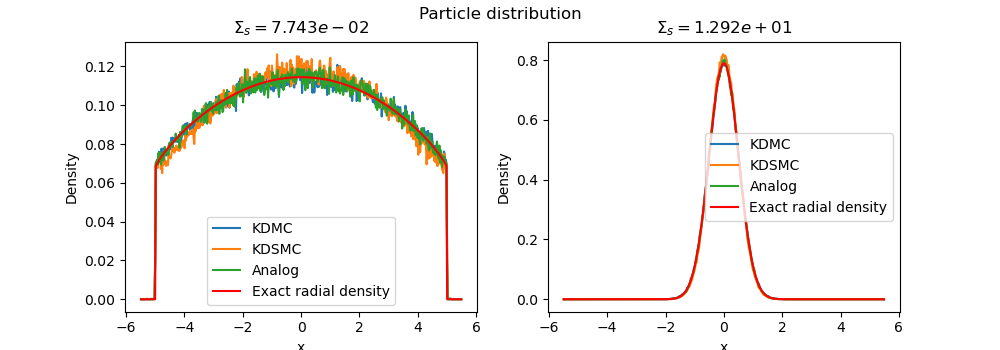

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
indexSigma1 = 2
indexSigma2 = 7

ax1.plot(binCenter, KDMCTEE[indexSigma1, 0, :], label=f'KDMC')
ax1.plot(binCenter, KDSMCTEE[indexSigma1, 0, :], label=f'KDSMC')
ax1.plot(binCenter, analogTEE[indexSigma1, 0, :], label='Analog')
ax1.plot(binCenter, resy[indexSigma1, :], color='r', label='Exact radial density')

ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.set_title(f'$\Sigma_s = {sigmaArray[indexSigma1]:.3e}$')
ax1.legend()

ax2.plot(binCenter, KDMCTEE[indexSigma2, 0, :], label=f'KDMC')
ax2.plot(binCenter, KDSMCTEE[indexSigma2, 0, :], label=f'KDSMC')
ax2.plot(binCenter, analogTEE[indexSigma2, 0, :], label='Analog')
ax2.plot(binCenter, resy[indexSigma2, :], color='r', label='Exact radial density')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.set_title(f'$\Sigma_s = {sigmaArray[indexSigma2]:.3e}$')
ax2.legend()

plt.suptitle('Particle distribution')

In [5]:
# Compute error of distributions
KDMCErr = np.empty(shape=(nbSigma, repeats))
KDSMCErr = np.empty(shape=(nbSigma, repeats))
analogErr = np.empty(shape=(nbSigma, repeats))
for repeat in range(repeats):
    for i in range(nbSigma):
        analogErr[i, repeat] = stats.wasserstein_distance(resy[i, :], analogTEE[i, repeat, :])
        KDMCErr[i, repeat] = stats.wasserstein_distance(resy[i, :], KDMCTEE[i, repeat, :])
        KDSMCErr[i, repeat] = stats.wasserstein_distance(resy[i, :], KDSMCTEE[i, repeat, :])

# Average over repeats
KDMCAvgErr = KDMCErr.mean(axis=1)
KDSMCAvgErr = KDSMCErr.mean(axis=1)
analogAvgErr = analogErr.mean(axis=1)

Text(0.5, 1.0, 'Average Wasserstein error')

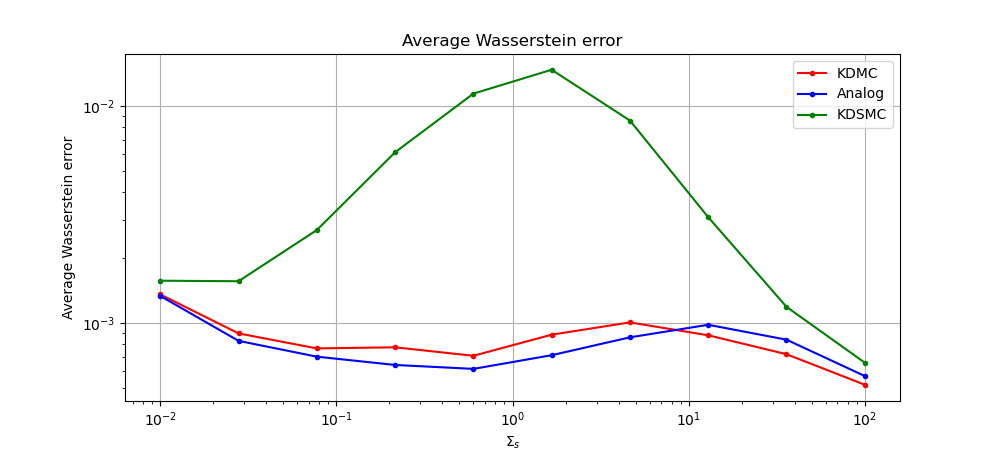

In [6]:
# Plot error
fig, ax1 = plt.subplots(figsize=(10, 4.5))

ax1.loglog(sigmaArray, KDMCAvgErr, '.-r', label='KDMC')
ax1.loglog(sigmaArray, analogAvgErr, '.-b', label='Analog')
ax1.loglog(sigmaArray, KDSMCAvgErr, '.-g', label='KDSMC')

ax1.set_xlabel('$\Sigma_s$')
ax1.set_ylabel('Average Wasserstein error')
ax1.legend()
ax1.grid()
ax1.set_title(f'Average Wasserstein error')